<ipython-input-1-ca66de8a8770>:13: RuntimeWarning: overflow encountered in add
  rates[t + 1, :] = rates[t, :] + kappa * (theta - rates[t, :]) * time_step + sigma * dW[t, :]
C:\Users\spark\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-1-ca66de8a8770>:13: RuntimeWarning: overflow encountered in add
  rates[t + 1, :] = rates[t, :] + kappa * (theta - rates[t, :]) * time_step + sigma * dW[t, :]
C:\Users\spark\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-1-ca66de8a8770>:13: RuntimeWarning: overflow encountered in add
  rates[t + 1, :] = rates[t, :] + kappa * (theta - rates[t, :]) * time_step + sigma * dW[t, :]


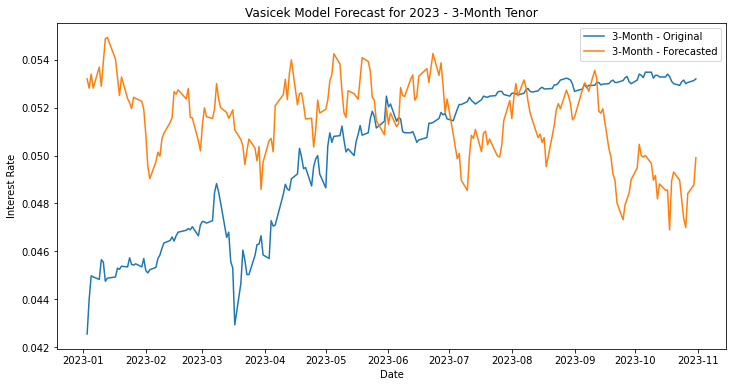

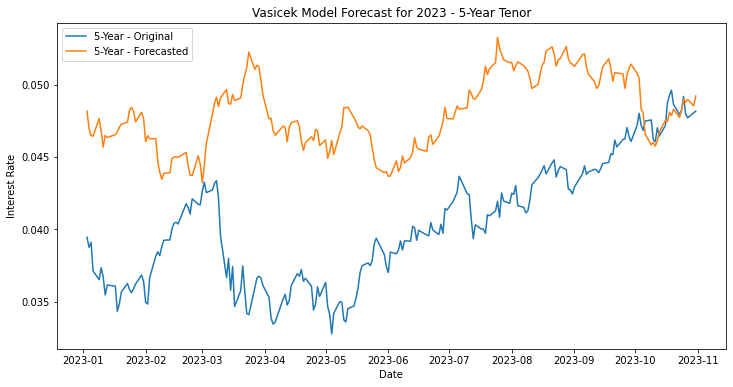

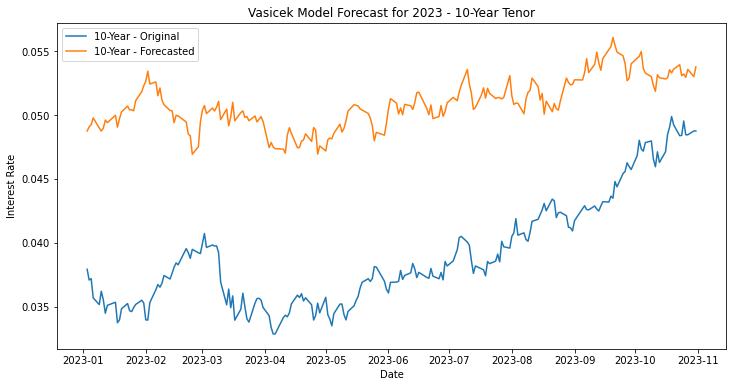

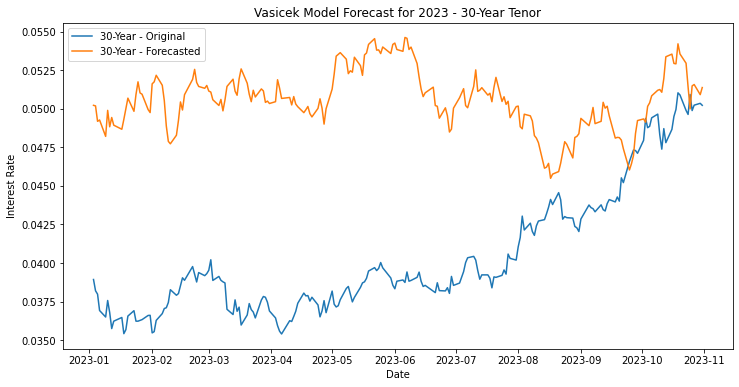

Original 2023 Data:
            3-Month   5-Year  10-Year  30-Year
Date                                          
2023-01-03  0.04255  0.03945  0.03793  0.03893
2023-01-04  0.04400  0.03875  0.03709  0.03820
2023-01-05  0.04498  0.03910  0.03720  0.03798
2023-01-06  0.04493  0.03712  0.03569  0.03692
2023-01-09  0.04483  0.03651  0.03517  0.03650
...             ...      ...      ...      ...
2023-10-25  0.05315  0.04918  0.04953  0.05092
2023-10-26  0.05300  0.04797  0.04845  0.04988
2023-10-27  0.05305  0.04770  0.04845  0.05023
2023-10-30  0.05313  0.04804  0.04875  0.05035
2023-10-31  0.05320  0.04816  0.04875  0.05022

[209 rows x 4 columns]

Forecasted 2023 Data:
             3-Month    5-Year   10-Year   30-Year
Date                                              
2023-01-03  0.053200  0.048160  0.048750  0.050220
2023-01-04  0.052812  0.046964  0.049073  0.050182
2023-01-05  0.053401  0.046474  0.049244  0.049183
2023-01-06  0.052816  0.046427  0.049772  0.049270
2023-01-09  0.05

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to simulate Vasicek model
def vasicek_simulation(params, initial_rate, time_step, num_steps, num_paths):
    kappa, theta, sigma = params
    dW = np.random.normal(0, np.sqrt(time_step), (num_steps, num_paths))
    rates = np.zeros((num_steps + 1, num_paths))
    rates[0, :] = initial_rate
    for t in range(num_steps):
        rates[t + 1, :] = rates[t, :] + kappa * (theta - rates[t, :]) * time_step + sigma * dW[t, :]
    return rates



# Calibration function for Vasicek model
def vasicek_calibration(params, data, time_step, num_steps):
    initial_rate = data.iloc[0]
    simulated_rates = vasicek_simulation(params, initial_rate, time_step, num_steps, num_paths=1)
    return np.sum((simulated_rates[:, 0] - data) ** 2)

# Load combined data
combined_data = pd.read_csv('interest_rate_data.csv', index_col='Date', parse_dates=True)/100
original_2023_data = combined_data.loc['2023-01-01':'2023-12-31']

# Set time step and number of steps for simulation
time_step = 1
num_steps = len(combined_data.loc['2000-01-01':'2022-12-31']) - 1 #as we are using 2000 to 2022 for calibration

# Initial guess for parameters
initial_guess = [0.05, 0.05, 0.05] #kappa, theta, sigma

# Set a seed for reproducibility
seed = 50  # We can choose any integer

# Calibrate using historical data from 2000 to 2022 for each tenor
calibrated_params = {
    tenor: minimize(vasicek_calibration, initial_guess, args=(combined_data[tenor].loc['2000-01-01':'2022-12-31'], time_step, num_steps)).x
    for tenor in combined_data.columns
}

# Monte Carlo simulation for 2023
num_paths = 5000
simulation_results = {
    tenor: vasicek_simulation(params, combined_data[tenor].iloc[-1], time_step, len(original_2023_data)-1, num_paths)
    for tenor, params in calibrated_params.items()
}

# Create DataFrame with original 2023 data and forecasted data
original_2023_data = combined_data.loc['2023-01-01':'2023-12-31']
forecasted_2023_data = pd.DataFrame({tenor: np.mean(paths, axis=1) for tenor, paths in simulation_results.items()}, index=original_2023_data.index)

# Calculate the difference between original and forecasted data
difference_data = original_2023_data - forecasted_2023_data

# Calculate the standard deviation of differences
std_dev_difference = difference_data.std()

# Calculate the root mean squared error (RMSE)
rmse_per_tenor = np.sqrt(np.mean(difference_data**2,axis=0))

# Visualize the results for each tenor
for tenor in combined_data.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(original_2023_data.index, original_2023_data[tenor], label=f"{tenor} - Original")
    plt.plot(original_2023_data.index, forecasted_2023_data[tenor], label=f"{tenor} - Forecasted")
    plt.title(f"Vasicek Model Forecast for 2023 - {tenor} Tenor")
    plt.xlabel("Date")
    plt.ylabel("Interest Rate")
    plt.legend()
    plt.show()

# Display the DataFrames for Vasicek model
print("Original 2023 Data:")
print(original_2023_data)
print("\nForecasted 2023 Data:")
print(forecasted_2023_data)
print("\nDifference between Original and Forecasted Data:")
print(difference_data)
print("\nMean Difference between Original and Forecasted Data:")
print(difference_data.mean())
print("Standard Deviation of Differences:")
print(std_dev_difference)
print("Root Mean Squared Error (RMSE) for Each Tenor:")
print(rmse_per_tenor)
print(calibrated_params)